In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import gmean
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from src.config import get_interim_dir, get_validation_barcodes, get_common_barcodes

In [41]:
ds = "full"

### Comparing filtered barcodes to original screen

In [42]:
original_barcodes = pd.read_csv(get_common_barcodes(), sep="\t")
orig_filtered_counts = original_barcodes["Filtered"].value_counts()
(orig_filtered_counts/orig_filtered_counts.sum()).sort_index()

Filtered
0    0.815709
1    0.121567
2    0.003683
3    0.037609
4    0.015402
5    0.006031
Name: count, dtype: float64

In [43]:
validation_barcodes = pd.read_csv(get_validation_barcodes(downsample=ds), sep="\t")
val_filtered_counts = validation_barcodes["Filtered"].value_counts()
print(ds)
print((val_filtered_counts/val_filtered_counts.sum()).sort_index())
print("\n")

full
Filtered
0    0.996325
2    0.000141
3    0.003534
Name: count, dtype: float64




In [68]:
validation_barcodes["Gene"].nunique()

744

In [44]:
validation_barcodes.shape

(7074, 8)

99.6% of the barcodes in the new subscreen passed the filter checks compared to only 81.6% in the original screen.

In [45]:
candidate_list = pd.read_csv("../../outlier_analysis/artifacts/candidates.txt", sep="\t", names=['Gene'])["Gene"]
validation_gene_list = validation_barcodes["Barcode"].str.rsplit("-", n=1, expand=True)[0].unique()

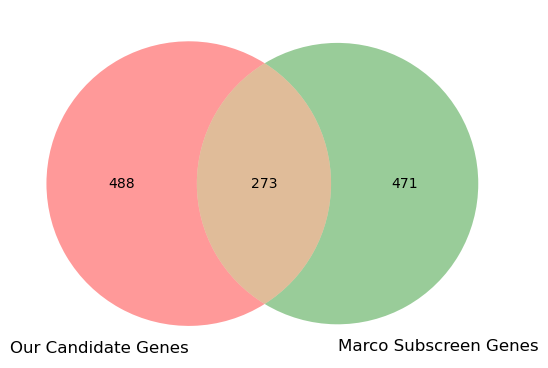

In [46]:
import pylab as plt
from matplotlib_venn import venn2

set1 = set(candidate_list)
set2 = set(validation_gene_list)

venn2([set1, set2], ('Our Candidate Genes', 'Marco Subscreen Genes'))
plt.show()

In [47]:
pd.read_csv("../../outlier_analysis/artifacts/candidates.txt", sep="\t", names=['Gene'])

,Gene
0,1110059E24Rik
1,2700062C07Rik
2,9030619P08Rik
3,AA792892
4,Aars
...,...
756,Zfp959
757,Zmynd8
758,Zpld1
759,Zpr1


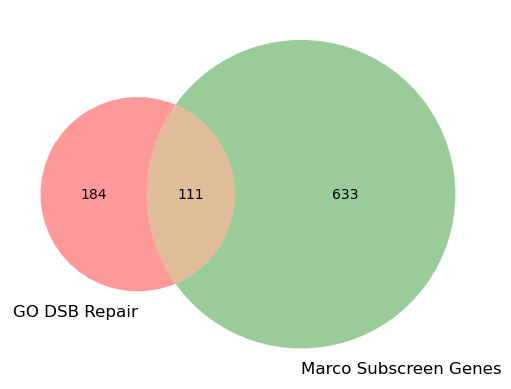

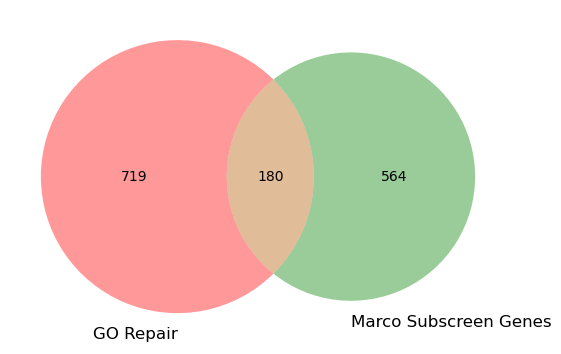

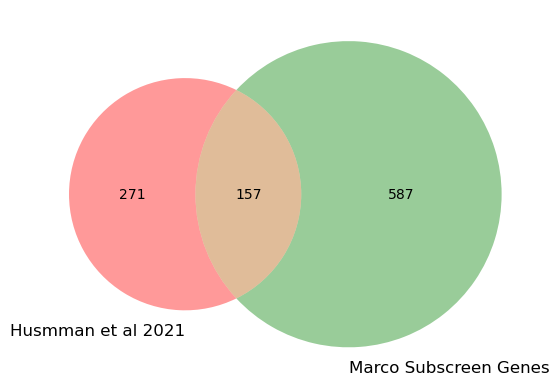

In [48]:
details = pd.read_pickle("../../outlier_detection/artifacts/paired-replicates.robust_cov.700/augmented_with_GO_outlier_results.pkl")

GODSBRepairgenes = set(details[details[("Global", "isGODSBRepair")]].index.to_list())
venn2([GODSBRepairgenes, set2], ('GO DSB Repair', 'Marco Subscreen Genes'))
plt.show()

GORepairgenes = set(details[details[("Global", "isGORepair")]].index.to_list())
venn2([GORepairgenes, set2], ('GO Repair', 'Marco Subscreen Genes'))
plt.show()


Hussmanngenes = set(details[details[("Gene Sets", "Adamson")]].index.to_list())
venn2([Hussmanngenes, set2], ('Husmman et al 2021', 'Marco Subscreen Genes'))
plt.show()


### Comparing T1 profiles between old and new screen

In [49]:
FILTER_COUNT = 700
subscreen_aliases = ["MBsub1", "MBsub2", "MBsub3"]

aliases = ["MB01", "MB02"]

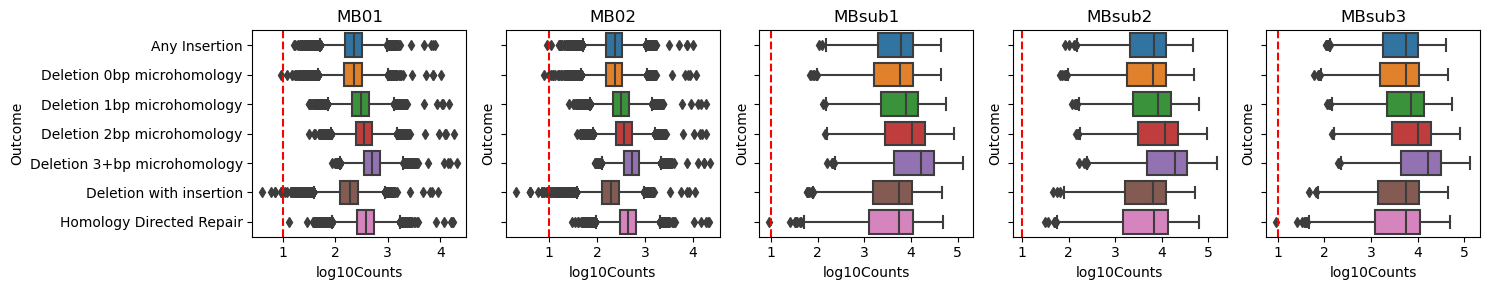

In [50]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3), sharey=True)

for i, alias in enumerate(aliases + subscreen_aliases): 
    if alias in aliases:
        X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.{}.pkl".format(alias, FILTER_COUNT))
    else:
        X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.{}.full.pkl".format(alias, FILTER_COUNT))
    X = X.loc[~(X==0).any(axis=1)]
    X.columns.name = "Outcome"
    X.head()
    X = X.loc[:, (X != 0).any(axis=0)]
    boxplot_data = np.log10(X.sort_index(axis=1).stack()).reset_index().rename(columns={0: "log10Counts"})
    boxplot_data["log10median <= 1"] = boxplot_data[["Outcome", "log10Counts"]].groupby("Outcome").median()["log10Counts"] <= 1
    sns.boxplot(data=boxplot_data, y="Outcome", x="log10Counts", ax=ax[i])
    ax[i].axvline(1, ls="--", color="red")
    ax[i].title.set_text(alias)
    plt.tight_layout()
plt.show()

On average, there seems to be more deletions with insertions this time around. But the dataset seems cleaner, with less "outlying" points. HDR events seem to be LESS in the newer screens relative to other events.

In [51]:
data = {}
for alias in aliases + subscreen_aliases:
    if alias in aliases:
        X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.{}.pkl".format(alias, FILTER_COUNT))
    else:
        X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.{}.full.pkl".format(alias, FILTER_COUNT))
    data[alias] = X
data = pd.concat(list(data.values()))
d_norm = data.div(data.sum(axis=1), axis=0)
d_norm.head()

lumc_category                               Deletion 0bp microhomology  \
Target Alias Gene          Barcode                                       
T1     MB01  0610009B22Rik 0610009B22Rik-1                    0.096128   
                           0610009B22Rik-2                    0.098854   
                           0610009B22Rik-3                    0.097005   
                           0610009B22Rik-4                    0.081714   
                           0610009B22Rik-5                    0.073362   

lumc_category                               Deletion 1bp microhomology  \
Target Alias Gene          Barcode                                       
T1     MB01  0610009B22Rik 0610009B22Rik-1                    0.129951   
                           0610009B22Rik-2                    0.166905   
                           0610009B22Rik-3                    0.116970   
                           0610009B22Rik-4                    0.112324   
                           0610009B22Rik-5                    0.151432   

lumc_category                               Deletion 2bp microhomology  \
Target Alias Gene          Barcode                                       
T1     MB01  0610009B22Rik 0610009B22Rik-1                    0.147308   
                           0610009B22Rik-2                    0.127507   
                           0610009B22Rik-3                    0.185052   
                           0610009B22Rik-4                    0.173277   
                           0610009B22Rik-5                    0.148293   

lumc_category                               Deletion with insertion  \
Target Alias Gene          Barcode                                    
T1     MB01  0610009B22Rik 0610009B22Rik-1                 0.085002   
                           0610009B22Rik-2                 0.079513   
                           0610009B22Rik-3                 0.078065   
                           0610009B22Rik-4                 0.068139   
                           0610009B22Rik-5                 0.094155   

lumc_category                               Homology Directed Repair  \
Target Alias Gene          Barcode                                     
T1     MB01  0610009B22Rik 0610009B22Rik-1                  0.242101   
                           0610009B22Rik-2                  0.183739   
                           0610009B22Rik-3                  0.164832   
                           0610009B22Rik-4                  0.188714   
                           0610009B22Rik-5                  0.166732   

lumc_category                               Any Insertion  \
Target Alias Gene          Barcode                          
T1     MB01  0610009B22Rik 0610009B22Rik-1       0.097908   
                           0610009B22Rik-2       0.101719   
                           0610009B22Rik-3       0.085999   
                           0610009B22Rik-4       0.131488   
                           0610009B22Rik-5       0.112985   

lumc_category                               Deletion 3+bp microhomology  
Target Alias Gene          Barcode                                       
T1     MB01  0610009B22Rik 0610009B22Rik-1                     0.201602  
                           0610009B22Rik-2                     0.241762  
                           0610009B22Rik-3                     0.272076  
                           0610009B22Rik-4                     0.244344  
                           0610009B22Rik-5                     0.253040

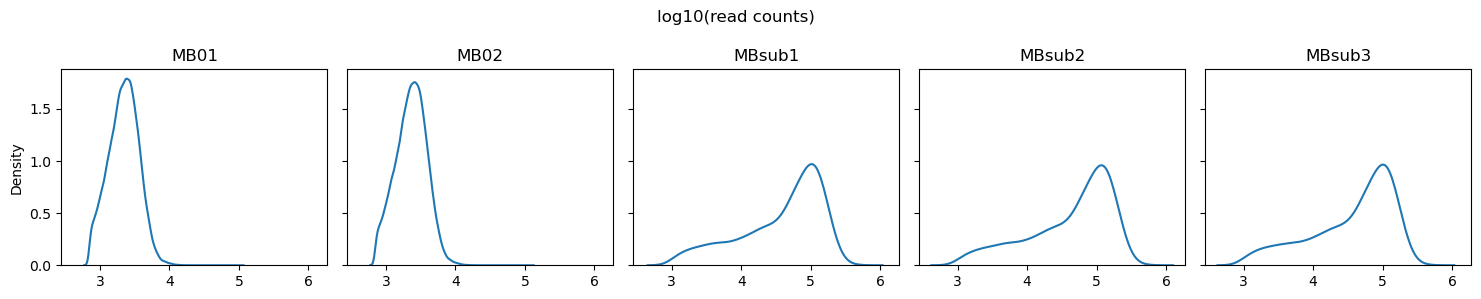

In [52]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)

for i, alias in enumerate(aliases + subscreen_aliases):
    X = data.xs(alias, level="Alias")
    sns.kdeplot(np.log10(X.sum(axis=1)), ax=axes[i])
    axes[i].set_title(alias)
plt.suptitle("log10(read counts)".format(alias))
plt.tight_layout()
plt.show()

In [53]:
def get_mean_correlation(square_df):
    mask = np.ones(square_df.shape, dtype='bool')
    mask[np.triu_indices(len(square_df))] = False
    square_df[~mask] = np.nan
    square_df_mean = np.nanmean(square_df.values)
    return square_df_mean


sample_barcodes = d_norm.index.get_level_values(3).value_counts().sort_values(ascending=False)[:500].sample(500, random_state=1, replace=False).index.to_list()

idx = pd.IndexSlice

oldscreen_mean = []
subscreen_mean = []
between_mean = []

for bc in sample_barcodes:
    cors = d_norm.loc[idx[:,:,:,bc], :].T.corr()
    is_subscreen = cors.index.get_level_values(1).to_series().str.contains("sub")
    cors_oldscreen = cors.loc[~is_subscreen.values, ~is_subscreen.values]
    oldscreen_mean.append(get_mean_correlation(cors_oldscreen))

    cors_subscreen = cors.loc[is_subscreen.values, is_subscreen.values]
    subscreen_mean.append(get_mean_correlation(cors_subscreen))

    cors_between = cors.loc[~is_subscreen.values, is_subscreen.values]
    between_mean.append(cors_between.values.mean())

In [69]:
cors

Target                             T1                                        
Alias                            MB01      MB02    MBsub1    MBsub2    MBsub3
Gene                            Obsl1     Obsl1     Obsl1     Obsl1     Obsl1
Barcode                       Obsl1-3   Obsl1-3   Obsl1-3   Obsl1-3   Obsl1-3
Target Alias  Gene  Barcode                                                  
T1     MB01   Obsl1 Obsl1-3  1.000000  0.851516  0.685940  0.688294  0.662707
       MB02   Obsl1 Obsl1-3  0.851516  1.000000  0.922452  0.927820  0.917093
       MBsub1 Obsl1 Obsl1-3  0.685940  0.922452  1.000000  0.997777  0.998919
       MBsub2 Obsl1 Obsl1-3  0.688294  0.927820  0.997777  1.000000  0.998184
       MBsub3 Obsl1 Obsl1-3  0.662707  0.917093  0.998919  0.998184  1.000000

(0.0, 1.0)

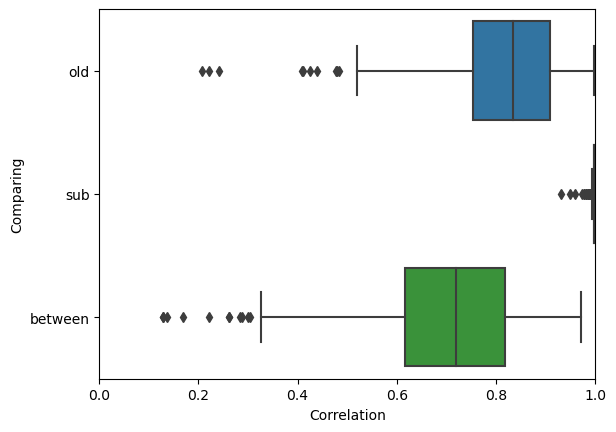

In [54]:
boxplot_df = pd.DataFrame({"old": oldscreen_mean, "sub": subscreen_mean, "between": between_mean})
boxplot_df = boxplot_df.stack().droplevel(0).reset_index().rename(columns={"index": "Comparing", 0: "Correlation"})
sns.boxplot(boxplot_df, y="Comparing", x="Correlation")
plt.xlim(0, 1)

There is almost perfect agreement between replicates for the subscreen. This is not the case for the old screen, but both screens seem to disagree with each other slightly.

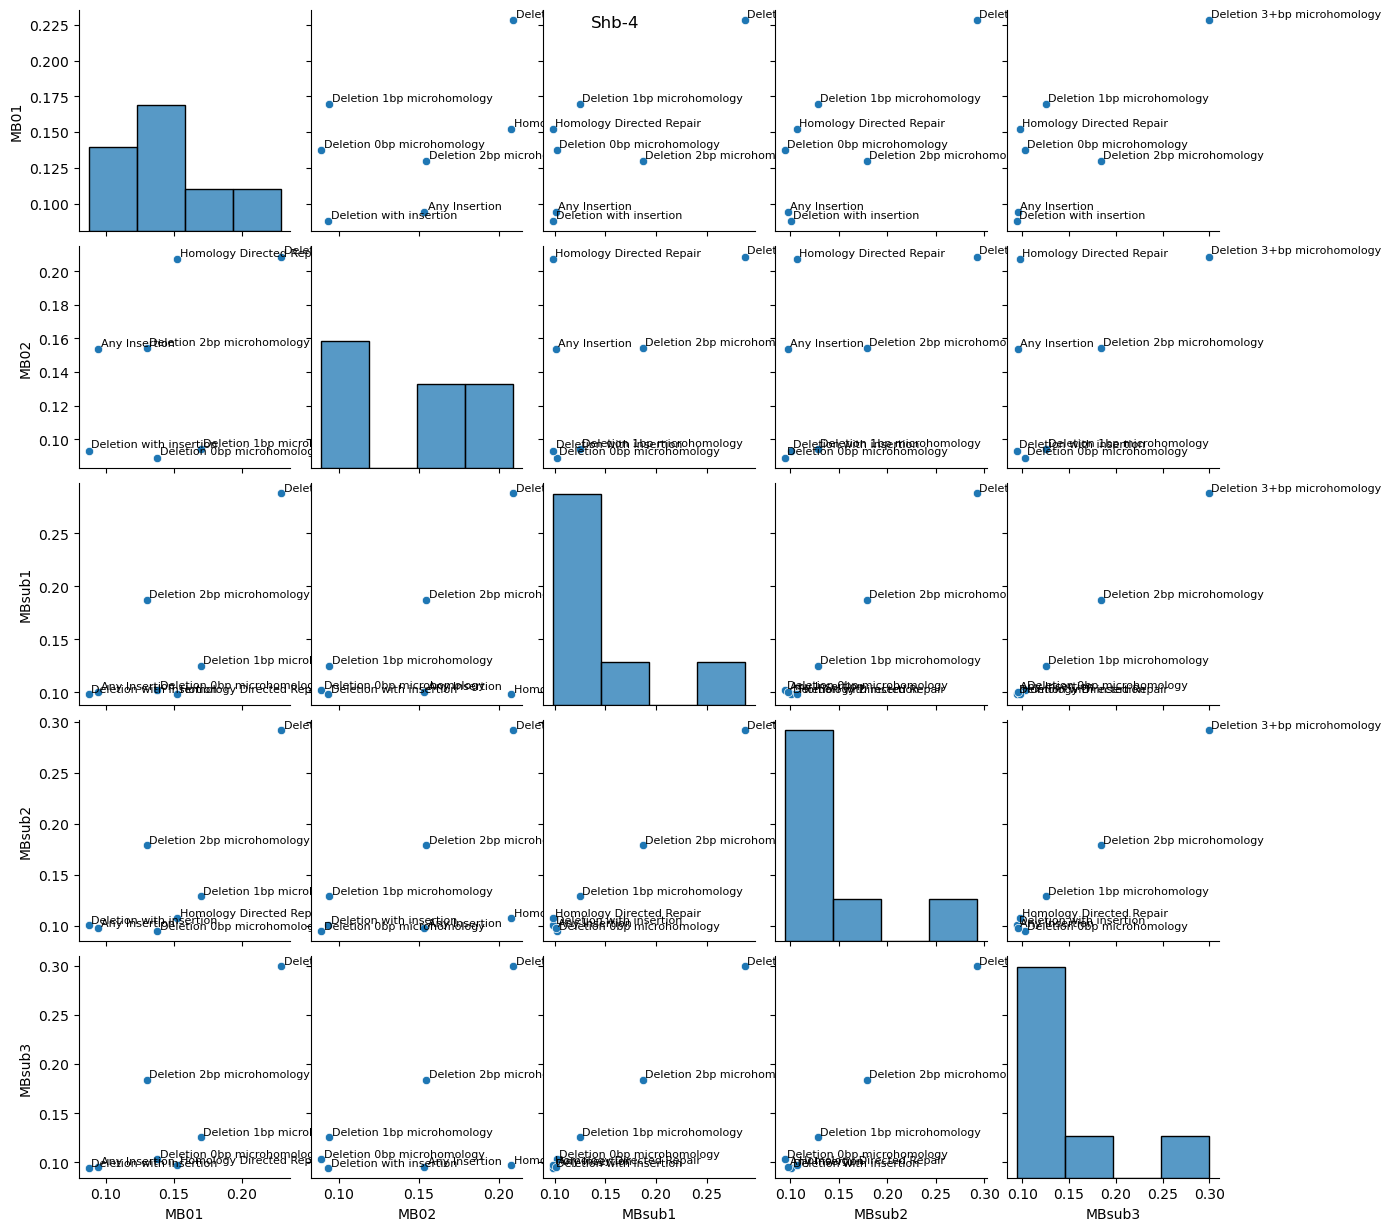

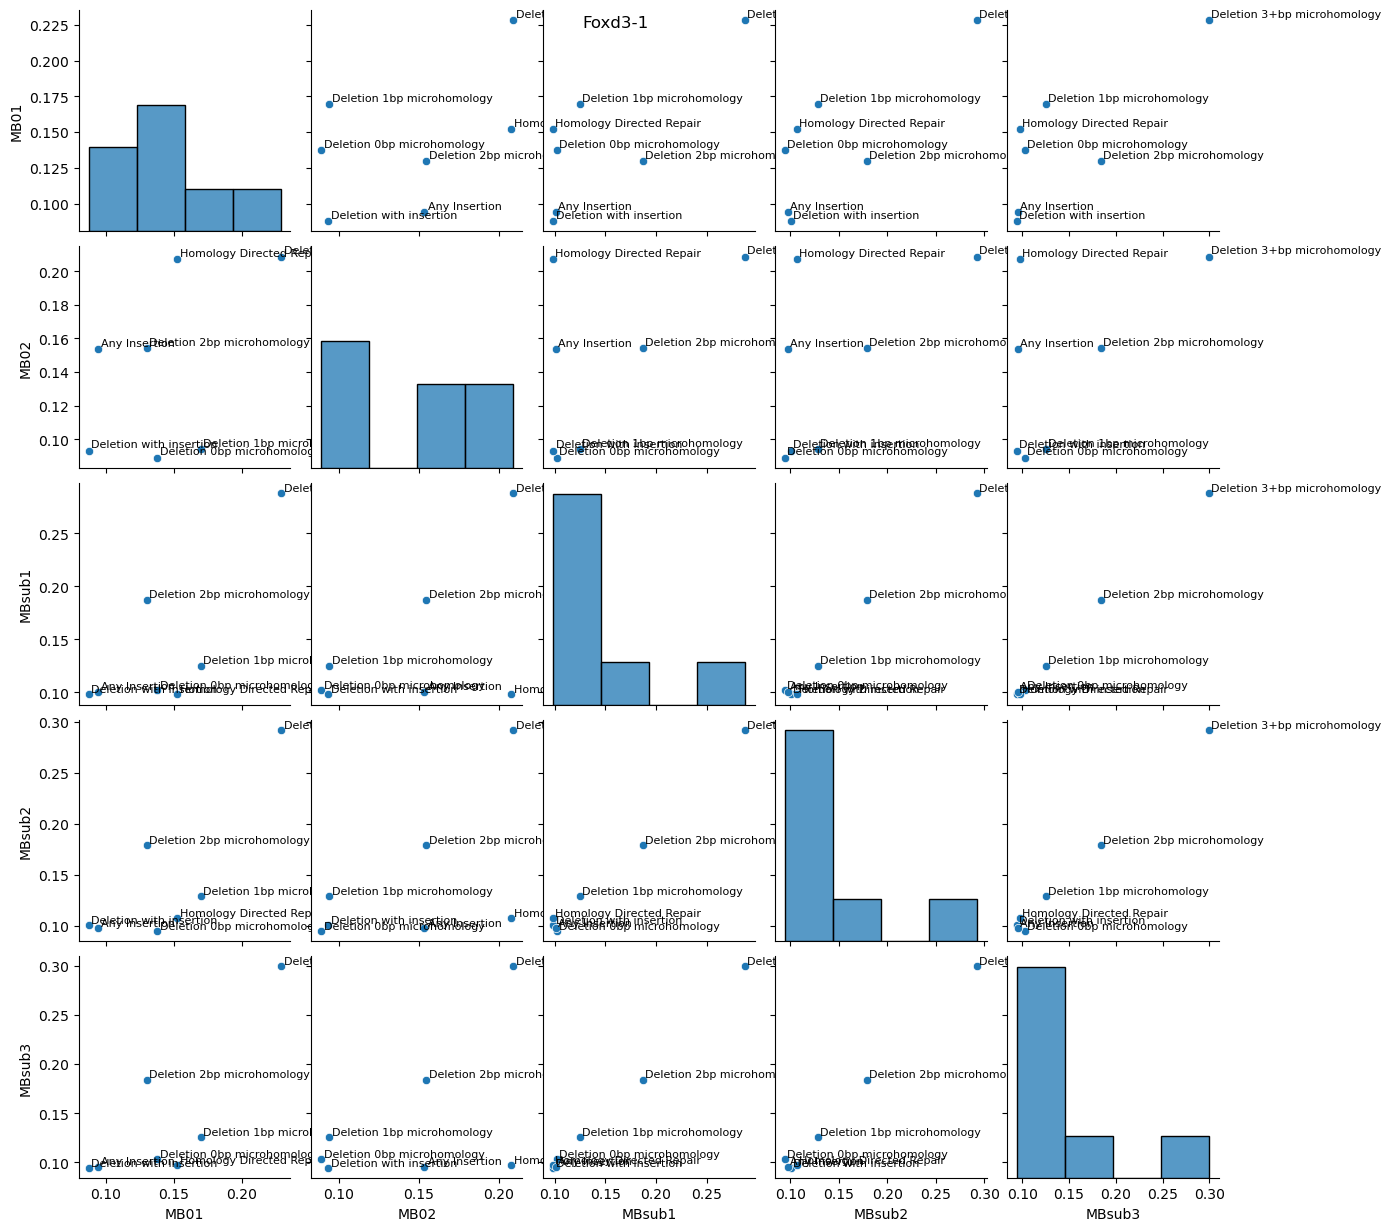

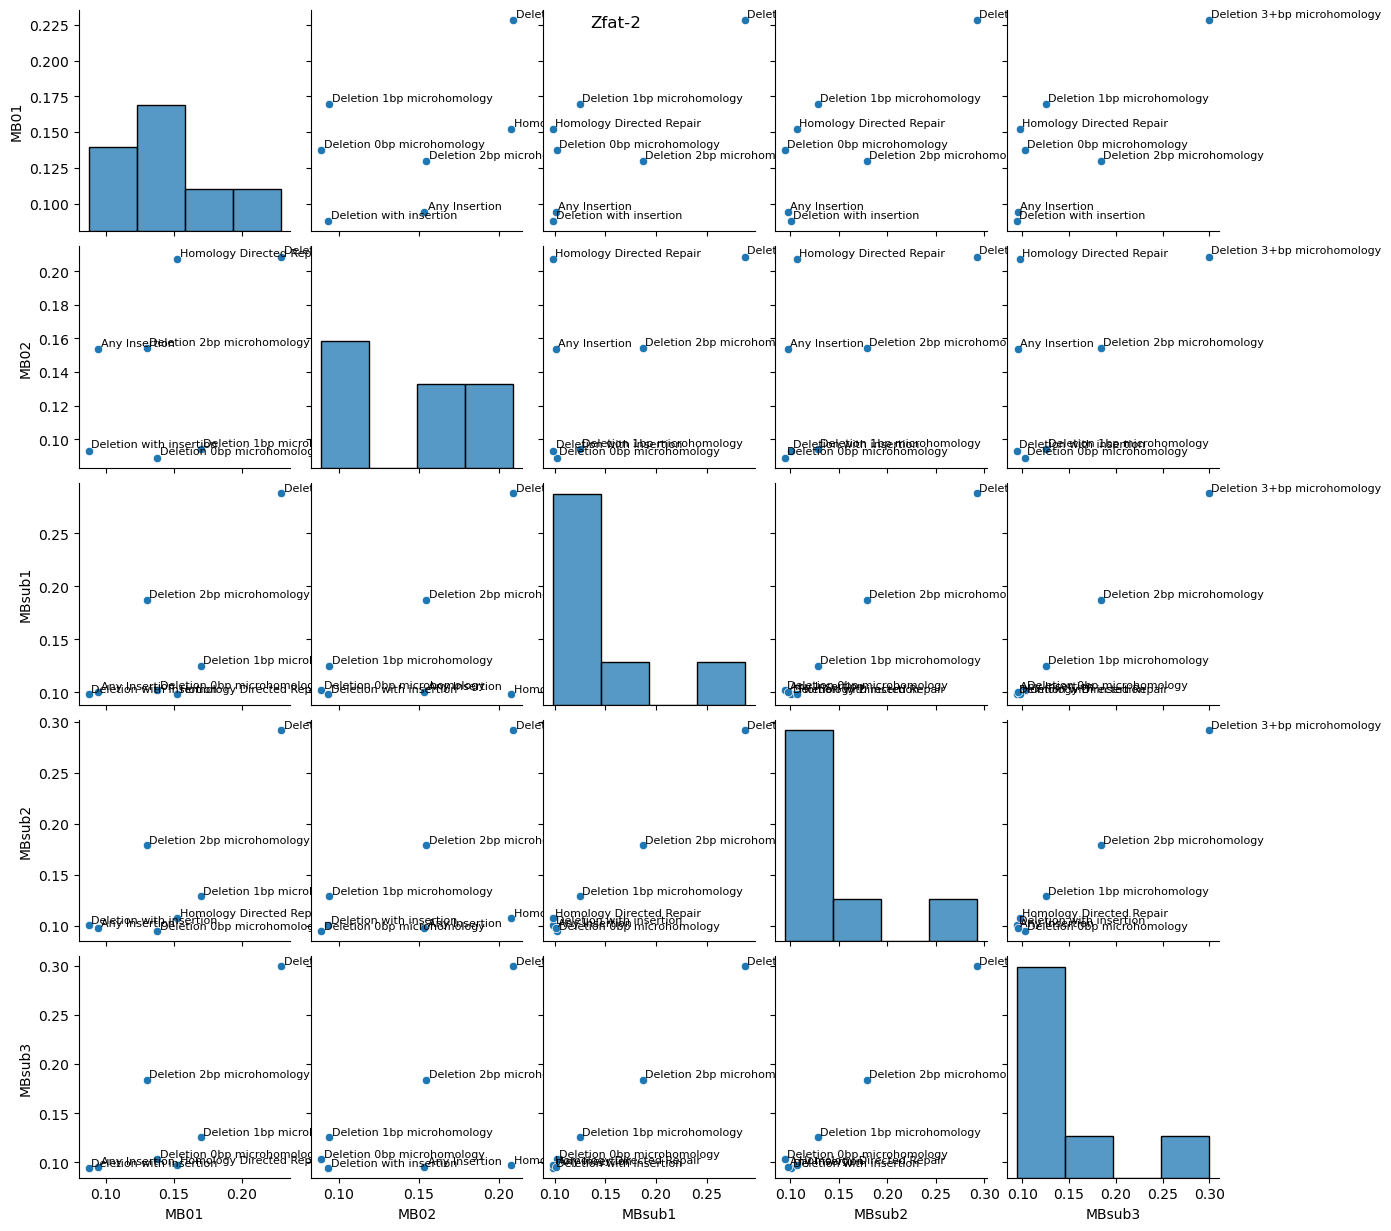

In [55]:
for sample_barcode in sample_barcodes[:3]:
    pairplot_df = d_norm.loc[idx[:,:,:,sample_barcodes[0]], :].T.droplevel(0, axis=1).droplevel(1, axis=1).droplevel(1, axis=1)
    labels = pairplot_df.index.to_list()
    g = sns.pairplot(pairplot_df)

    for i, c1 in enumerate(pairplot_df.columns):
        x = pairplot_df[c1]
        texts = x.index
        for j, c2 in enumerate(pairplot_df.columns):
            if i == j:
                continue
            y = pairplot_df[c2]
            ax = g.axes[j, i]
            for k, txt in enumerate(texts):
                ax.text(x[k] + 0.002, y[k] + 0.002, texts[k], size=8, fontdict=None)
    plt.suptitle(sample_barcode)
    plt.show()

Looking at some examples, the main form of disagreement comes in the form of HDR events. HDR events seem to be less frequent relative to the subscreen.

Why? Less template material? Maybe templates get used up/broken down over time and so other events can out-"grow" them in a deeper screen? Bit of a batch effect, might need to account for this during interpretation.

### Comparing log fold changes

In [56]:
# calculate geometric means
olds_d_norm = d_norm.loc[idx[:,"MB01",:,:]]
pseudo_controls = pd.read_csv("../../outlier_detection/artifacts/final_gene_list.tsv", sep="\t", skiprows=2)["Gene"][-100:].to_list()
olds_gmean = pd.Series(gmean(olds_d_norm.loc[idx[:,pseudo_controls,:]]), index=d_norm.columns)

subs_d_norm = d_norm.loc[idx[:,"MBsub3",:,:]]
subs_gmean =  pd.Series(gmean(subs_d_norm.loc[idx[:,"NonTargeting",:]]), index=d_norm.columns)


In [57]:
# get common genes
common_barcodes = np.intersect1d(subs_d_norm.index.get_level_values(2), olds_d_norm.index.get_level_values(2))

In [58]:
olds_d_norm = olds_d_norm.loc[idx[:,:,common_barcodes]]
subs_d_norm = subs_d_norm.loc[idx[:,:,common_barcodes]]

In [59]:
olds_d_log2fc = np.log2(olds_d_norm/olds_gmean)
subs_d_log2fc = np.log2(subs_d_norm/subs_gmean)

<AxesSubplot: xlabel='Log2FC', ylabel='lumc_category'>

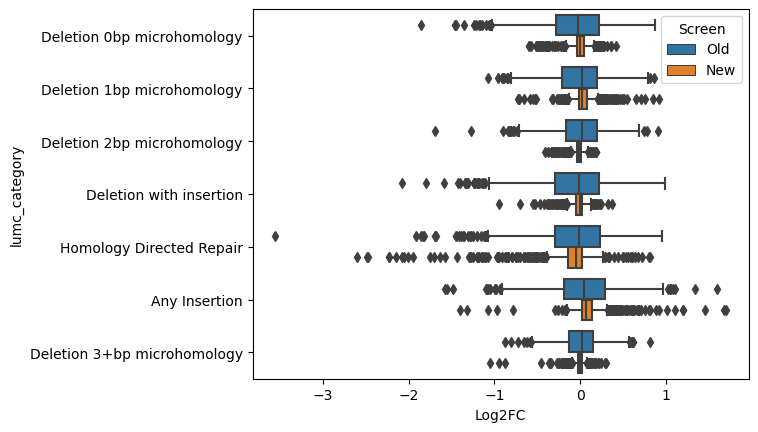

In [60]:
boxplot1_df = olds_d_log2fc.reset_index(drop=True).stack().reset_index().rename(columns={0: "Log2FC"})
boxplot2_df = subs_d_log2fc.reset_index(drop=True).stack().reset_index().rename(columns={0: "Log2FC"})
boxplot_df = pd.concat([boxplot1_df, boxplot2_df], keys={"Old", "New"}, names=["Screen"]).reset_index().iloc[:,[0,3,4]]
sns.boxplot(boxplot_df, x="Log2FC", y="lumc_category", hue="Screen")

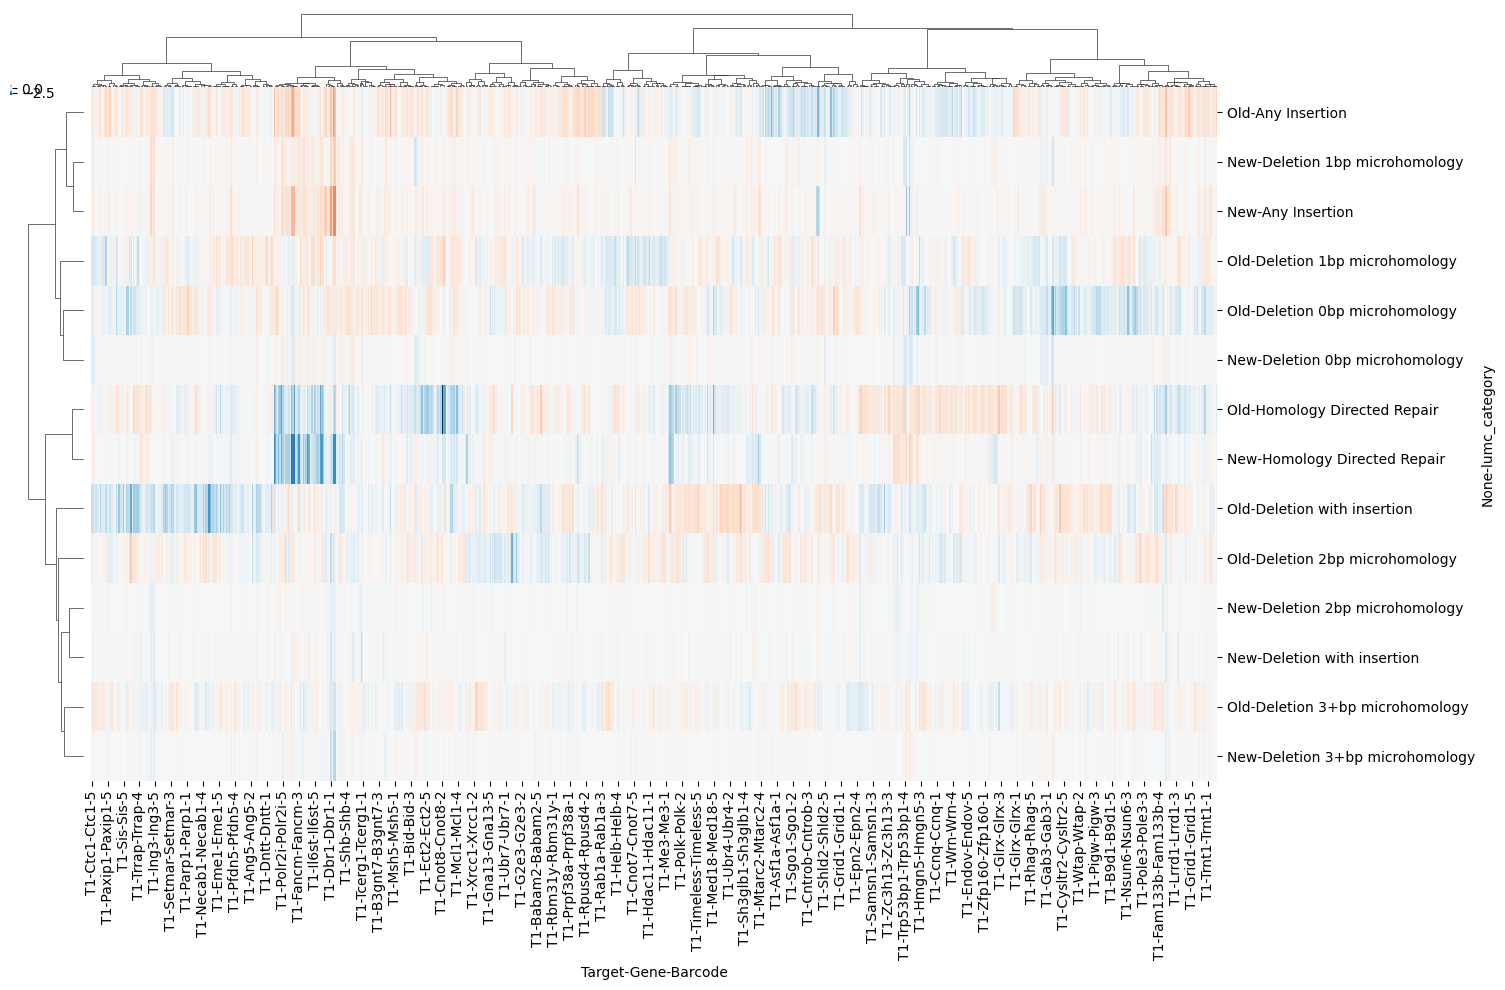

In [61]:
cluster_df = pd.concat([olds_d_log2fc, subs_d_log2fc], keys=["Old", "New"], axis=1)

sns.clustermap(cluster_df.T, metric="correlation", \
               method="ward", figsize=(15, 10), \
                center=0, dendrogram_ratio=(.05, .1), \
                    cmap="RdBu_r", cbar_pos=(0, .9, .001, .01), \
                        vmin=None, vmax=None)

The mutational outcomes and their logFC don't seem to correlation very well between replicates, at least for some mutation types. Insertions, deletions with 3+ bp microhomologies and HDR events seem to pair reasonably nicely. Other events like 2bp deletions with insertions and 2bp microhomologies do not. 

Deletion with insertions are rare, and possibly quite noisy, which means more volitile LogFC changes in the old screen. Could be the same for 2bp microhomology events.

In [62]:
gene_scores = pd.read_csv("../../outlier_detection/artifacts/final_gene_list.tsv", sep="\t", skiprows=2).iloc[:,[0, 5]]
gene_scores = gene_scores.rename(columns={"Unnamed: 5": "Rank"}).set_index("Gene")
common_genes = np.intersect1d(pd.Series(common_barcodes).str.rsplit("-", n=1, expand=True)[0].unique(), gene_scores.index.to_numpy())
common_genes = gene_scores.loc[common_genes].sort_values("Rank")
common_genes.head()

,Rank
Gene,
H2ax,5.0
Xrcc6,9.0
Zfp959,14.0
Dbr1,15.0
Rnf8,29.0


<AxesSubplot: xlabel='lumc_category', ylabel='Gene-Screen'>

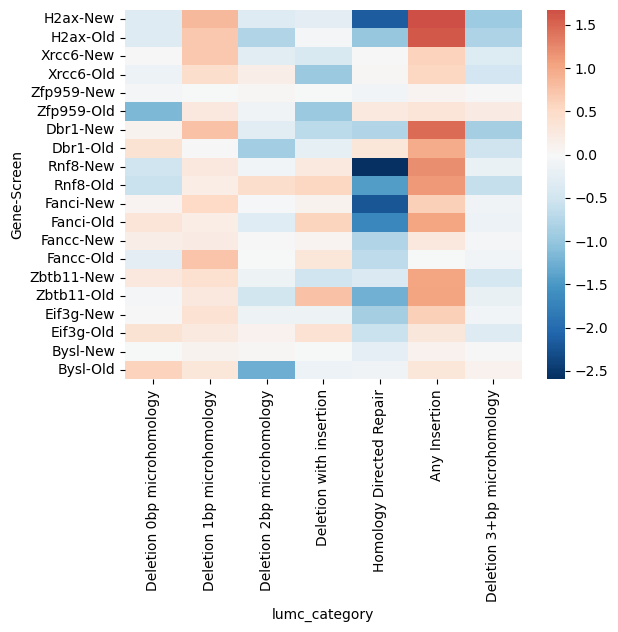

In [63]:
mini_cluster_df = pd.concat([olds_d_log2fc, subs_d_log2fc], keys=["Old", "New"], axis=0, names=["Screen"])
mini_cluster_df = mini_cluster_df.loc[idx[:,:, common_genes.index.to_list(),:]].groupby(["Screen", "Gene"]).first().swaplevel().sort_index()

sns.heatmap(mini_cluster_df.loc[idx[common_genes.head(10).index.to_list(),:]], center=0, cmap="RdBu_r", vmin=None, vmax=None)

# sns.clustermap(mini_cluster_df.T, \
#                method="average", figsize=(15, 3), \
#                 center=0, dendrogram_ratio=(.05, .1), \
#                     cmap="RdBu", cbar_pos=(0, .9, .001, .01), \
#                         vmin=None, vmax=None)

Looking at some of the paired values, we can see that many patterns repeat between the old and the new screens, but some mutation types seem to be more "volitile" than others. For example, Deletion 2bp microhomology seems to disagree between pairs. Also of note, Zfp959 and Bysl seem to have much weaker effects in this screen compared to the previous screens. So here we can see both the value in the new screen and the issues with the previous screen. 

In [64]:
(np.sign(mini_cluster_df).groupby("Gene").sum()/2).abs().sum().sort_values(ascending=False)/common_genes.shape[0]

lumc_category
Homology Directed Repair       0.671806
Any Insertion                  0.585903
Deletion 1bp microhomology     0.552863
Deletion with insertion        0.541850
Deletion 0bp microhomology     0.528634
Deletion 2bp microhomology     0.491189
Deletion 3+bp microhomology    0.480176
dtype: float64

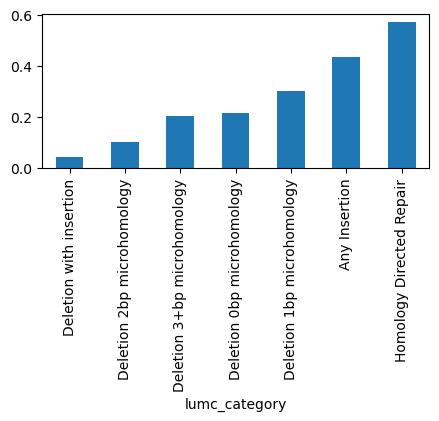

In [65]:
old_df = mini_cluster_df.xs("Old", level="Screen")
new_df = mini_cluster_df.xs("New", level="Screen")

plt.figure(figsize=(5, 2))
mut_corr_df = old_df.corrwith(new_df).sort_values()
mut_corr_df.plot.bar()
plt.show()

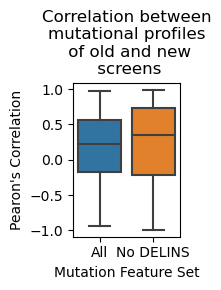

In [66]:
gene_corr_df = old_df.corrwith(new_df, axis=1)
gene_corr_df_nodelins = old_df[mut_corr_df.index[2:]].corrwith(new_df[mut_corr_df.index[2:]], axis=1)

boxplot_df = pd.concat([gene_corr_df, gene_corr_df_nodelins], keys={"All", "No DELINS"})\
    .reset_index().drop("Gene", axis=1).rename(columns={"level_0": "Mutation Feature Set", 0: "Correlation"})

plt.figure(figsize=(2, 3))

sns.boxplot(data=boxplot_df, y="Correlation", x="Mutation Feature Set")

plt.ylabel("Pearon's Correlation")
plt.title("Correlation between\nmutational profiles\n of old and new\n screens")
plt.tight_layout()